# 2024 인공지능 실습 1차시: Search

2024년 3월 28일 목요일



```
# This is formatted as code
```


## 목차

1. Best-first search
2. Breadth-first search
3. Uniform-cost search
4. Depth-first search
5. Depth limited and Iterative deepening search
6. Greedy best-first search
7. A* search
8. Weighted A* search

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations

# 1. Problem, Node, PriorityQueue Class

In [ ]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwargs):
      """The constructor specifies the initial state, and possibly a goal
      state, if there is a unique goal. Your subclass's constructor can add
      other arguments."""
      self.__dict__.update(initial=initial, goal=goal, **kwargs)

    def actions(self, state):
      raise NotImplementedError

    def result(self, state, action):
      raise NotImplementedError

    def is_goal(self, state):
      return state == self.goal

    def action_cost(self, s, a, s1):
      return 1

    def h(self, node):
      return 0

    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

*   `__init__(self, initial, goal)` : 생성자(constructor)라고 불리며, 클래스의 객체(instance)를 생성할 때 처음 호출되는 메소드이다. 예를 들어 `Problem(initial, goal)`로 클래스의 객체를 만들 때 사용된다. 변수 initial은 탐색 문제의 초기 상태를 지정하며, start state을 나타낸다.

*   `actions(self, state)` : 주어진 상태에서 에이전트가 실행할 수 있는 모든 가능한 동작(액션)을 반환한다.

*   `result(self, state, action)` :  주어진 상태에서 주어진 동작을 실행했을 때의 결과 상태를 반환한다.

*   `is_goal(self, state)` : 주어진 상태가 goal state인지 여부를 판단하여 Boolean 값을 반환한다. Goal state인 경우 True를 반환하고, 그렇지 않은 경우 False를 반환한다.

*   `action_cost(self, s, a, s1)` : State s에서 action a를 취하여 state s1로 도달하는 경로의 비용을 반환한다.

*    `h(self, node)` : 주어진 노드에 대한 휴리스틱 값을 반환한다.

*   `__str__(self)` : 표준 파이썬 기능을 오버라이드하여 해당 클래스의 객체를 문자열로 표현한다.



In [ ]:
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    def __repr__(self):
      return '<{}>'.format(self.state)

    def __len__(self):
      return 0 if self.parent is None else (1 + len(self.parent))

    def __lt__(self, other):
      return self.path_cost < other.path_cost

*   `__init__(self, state, parent, action, path_cost)` : `Node` 클래스의 객체를 생성하는 생성자이다. `parent`는 현재 노드의 이전 노드를 나타내며, `action`은 부모 노드에서 현재 노드로 이동하는 데 필요한 행동이다. `path_cost`는 부모 노드로부터 현재 노드에 도달하는 비용이다.

*   `__repr__(self)` : 노드를 나타내는 문자열을 반환한다.

*   `__len__(self, other)` : 노드에서 부모 노드까지의 경로의 길이를 반환한다.

*   `__lt__(self, node)` : 현재 노드의 경로 비용이 다른 노드의 경로 비용보다 작은지 여부를 판단한다.

In [ ]:
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []
    return path_actions(node.parent) + [node.action]

def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None):
        return []
    return path_states(node.parent) + [node.state]

In [ ]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x):
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)

    def add(self, item):
        """Add item to the queue."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]

    def top(self):
      return self.items[0][1]

    def __len__(self):
      return len(self.items)

# 2. RouteProblem

<img src='https://wikidocs.net/images/page/189097/Fig_03_01.PNG' width=700px>

In [ ]:
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [ ]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""

    def __init__(self, initial=None, goal=None, **kwargs):
      super().__init__(initial=initial, goal=goal, **kwargs)

    def actions(self, state):
        """The places neighboring `state`."""
        return self.map.neighbors[state]

    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state

    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]

    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])

In [ ]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them.
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs,
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)}
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = self.multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))


    def multimap(self, pairs) -> dict:
        "Given (key, val) pairs, make a dict of {key: [val,...]}."
        result = defaultdict(list)
        for key, val in pairs:
            result[key].append(val)
        return result

In [ ]:
romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118,
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146,
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101,
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142,
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294),
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)

In [ ]:
route = r1

# 3. Uninformed Search Algorithms

## Best-first search

In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

In [ ]:
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)

## Breadth-first search

In [ ]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure

In [ ]:
solution = breadth_first_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'F', 'B']
path cost: 450.0


## Uniform-cost search

In [ ]:
def g(n): return n.path_cost

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)

In [ ]:
solution = uniform_cost_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'R', 'P', 'B']
path cost: 418.0


## Depth-first search

In [ ]:
def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))

In [ ]:
solution = depth_first_bfs(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B']
path cost: 733.0


## Depth-limited and Iterative deepening search

In [ ]:
def depth_limited_search(problem, limit=10):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result

In [ ]:
def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result

*   *depth*: `sys.maxsize`

In [ ]:
def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)

In [ ]:
solution = depth_limited_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'T', 'L', 'M', 'D', 'C', 'P', 'B']
path cost: 733.0


In [ ]:
solution = iterative_deepening_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'F', 'B']
path cost: 450.0


# 4. Informed search algorithms

## Greedy best-first search

In [ ]:
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

In [ ]:
solution = greedy_bfs(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'F', 'B']
path cost: 450.0


## A* search

In [ ]:
def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))

In [ ]:
solution = astar_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'R', 'P', 'B']
path cost: 418.0


## Weighted A* search

In [ ]:
def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))

In [ ]:
solution = weighted_astar_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

['A', 'S', 'F', 'B']
path cost: 450.0


# 5. Reporting Summary Statistics on Search Algorithms

In [ ]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()

    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)


def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts;
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')

def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))

*   Search algorithms: `breadth_first_search, uniform_cost_search, depth_first_bfs, iterative_deepening_search, depth_limited_search, greedy_bfs, astar_search, weighted_astar_search`
*   RouteProblems: `r1, r2, r3, r4`



In [ ]:
report([breadth_first_search, uniform_cost_search, depth_first_bfs,
        iterative_deepening_search, depth_limited_search, greedy_bfs, astar_search,
        weighted_astar_search], [r1, r2, r3, r4])

breadth_first_search:
       18 nodes |       19 goal |  450 cost |      10 actions | RouteProblem('A', 'B')
       42 nodes |       43 goal | 1085 cost |      27 actions | RouteProblem('N', 'L')
       36 nodes |       37 goal |  837 cost |      22 actions | RouteProblem('E', 'T')
       30 nodes |       31 goal |  445 cost |      16 actions | RouteProblem('O', 'M')
      126 nodes |      130 goal | 2817 cost |      75 actions | TOTAL

uniform_cost_search:
       30 nodes |       13 goal |  418 cost |      16 actions | RouteProblem('A', 'B')
       42 nodes |       19 goal |  910 cost |      27 actions | RouteProblem('N', 'L')
       44 nodes |       20 goal |  805 cost |      27 actions | RouteProblem('E', 'T')
       30 nodes |       12 goal |  445 cost |      16 actions | RouteProblem('O', 'M')
      146 nodes |       64 goal | 2578 cost |      86 actions | TOTAL

depth_first_bfs:
       21 nodes |       10 goal |  733 cost |      16 actions | RouteProblem('A', 'B')
       30 nodes

# 6. GridProblem: Comparing reached states

In [ ]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwargs):
        Problem.__init__(self, initial=initial, goal=goal,
                         obstacles=set(obstacles) - {initial, goal}, **kwargs)

        self.directions = [(-1, -1), (0, -1), (1, -1),
                           (-1, 0),           (1,  0),
                           (-1, +1), (0, +1), (1, +1)]

    def action_cost(self, s, action, s1):
      return straight_line_distance(s, s1)

    def h(self, node):
      return straight_line_distance(node.state, self.goal)

    def result(self, state, action):
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state

    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles

In [ ]:
def random_lines(X=range(15, 130), Y=range(60), N=150, lengths=range(6, 12)):
    """The set of cells in N random lines of the given lengths."""
    result = set()
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(((0, 1), (1, 0)))
        result |= line(x, y, dx, dy, random.choice(lengths))
    return result

def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

In [ ]:
def plot_grid_problem(grid, solution, reached, title='Search'):
    """
    Use matplotlib to plot the grid, obstacles, solution, and reached.
    """
    plt.figure(figsize=(16, 10))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose([grid.initial]), 9**2, marker='D', c='green')
    plt.scatter(*transpose([grid.goal]), 9**2, marker='8', c='red')
    if solution != None:
      plt.scatter(*transpose(path_states(solution)), marker='s', c='blue')
      print('{} search: {:.1f} path cost'.format(title, solution.path_cost))
    if reached != None:
      reached = list(reached)
      plt.scatter(*transpose(reached), 1**2, marker='.', c='blue')
      print('{:,d} states reached'.format(len(reached)))
    plt.show()

def transpose(matrix): return list(zip(*matrix))

In [ ]:
random.seed(42) # To make this reproducible

frame = line(-10, 20, 0, 1, 20) | line(150, 20, 0, 1, 20)
cup = line(102, 44, -1, 0, 15) | line(102, 20, -1, 0, 20) | line(102, 44, 0, -1, 24)

d1 = GridProblem(obstacles=random_lines(N=100) | frame)
d2 = GridProblem(obstacles=random_lines(N=150) | frame)
d3 = GridProblem(obstacles=random_lines(N=200) | frame)
d4 = GridProblem(obstacles=random_lines(N=250) | frame)
d5 = GridProblem(obstacles=random_lines(N=300) | frame)
d6 = GridProblem(obstacles=cup | frame)
d7 = GridProblem(obstacles=cup | frame | line(50, 35, 0, -1, 10) | line(60, 37, 0, -1, 17) | line(70, 31, 0, -1, 19))

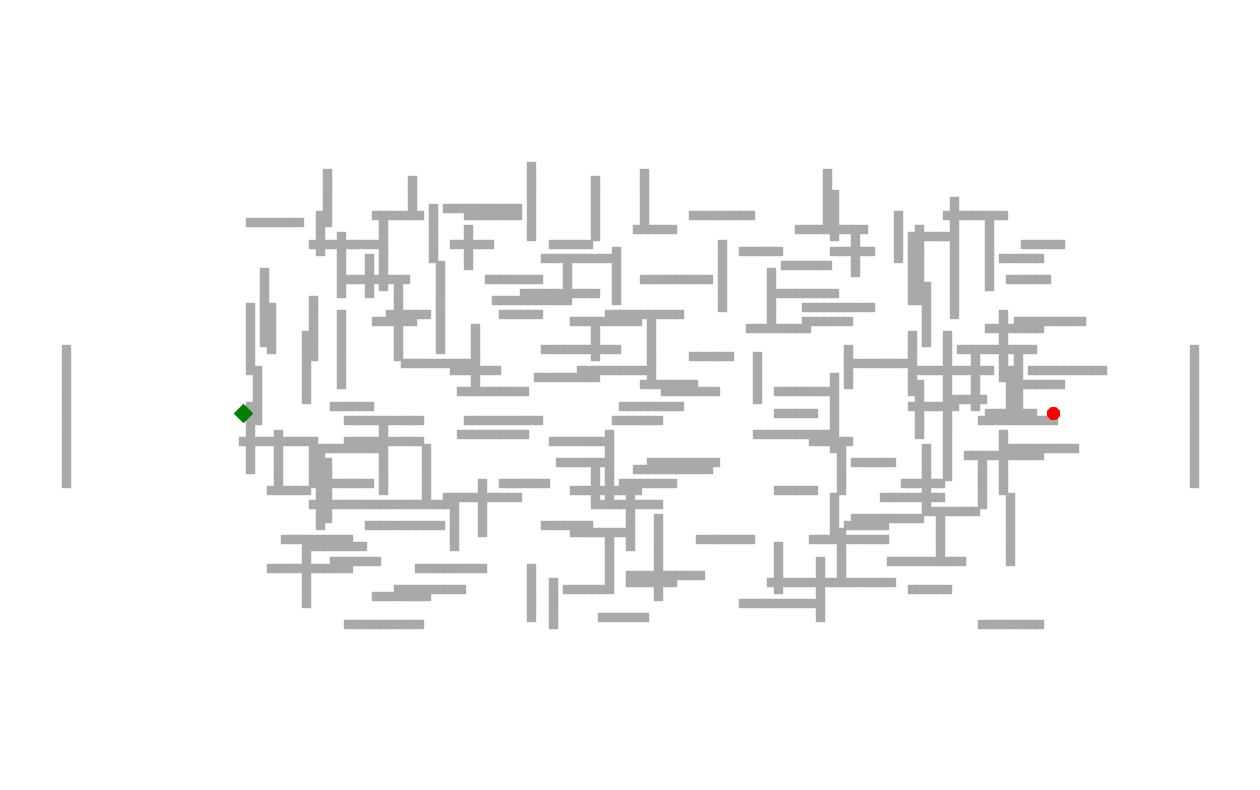

In [ ]:
plot_grid_problem(d3, solution=None, reached=None)

위의 `best_first_search` 함수에서 `reached` 변수 `global`로 변경 후 아래 알고리즘의 결과 시각화:

*   `uniform_cost_search`
*   `greedy_bfs`
*   `astar_search`
*   `weighted_astar_search`


In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    global reached
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

Uniform cost search search: 154.2 path cost


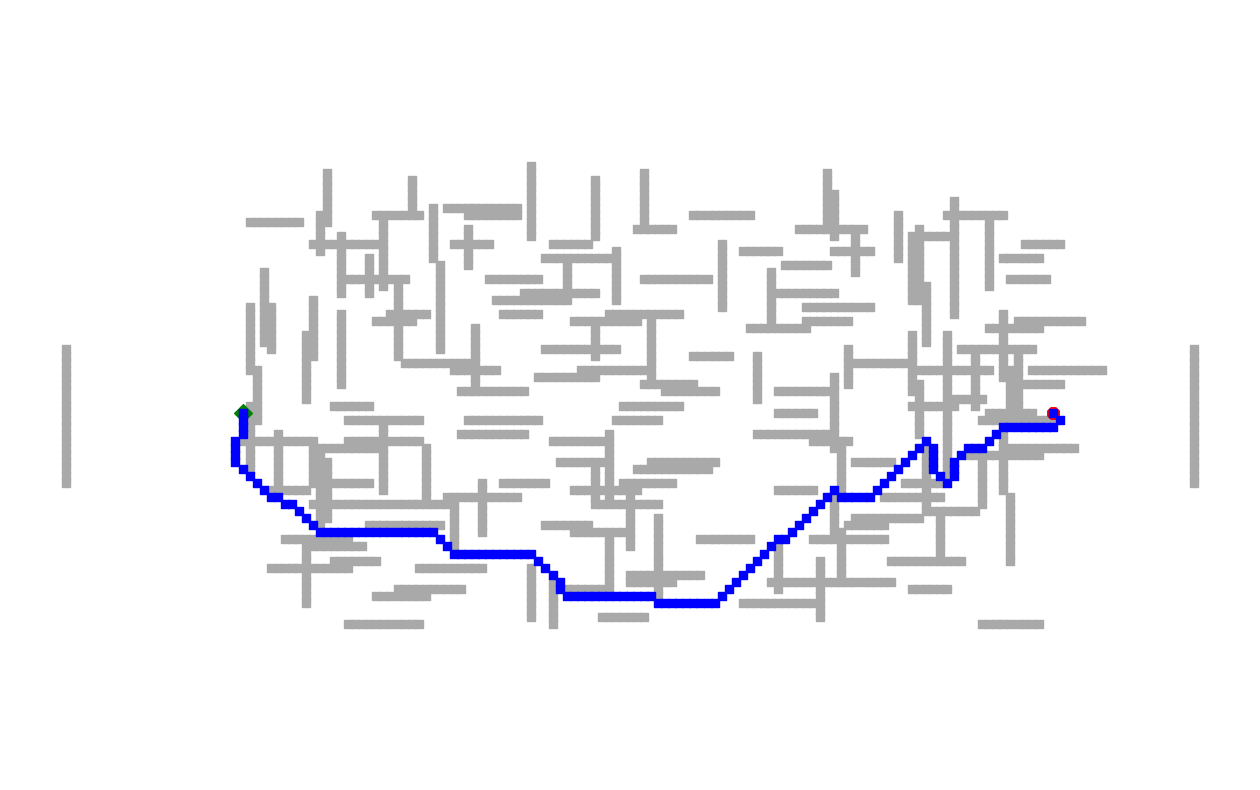

In [ ]:
solution = uniform_cost_search(d3)
plot_grid_problem(d3, solution, reached=None, title='Uniform cost search')

Greedy BFS search: 164.5 path cost
448 states reached


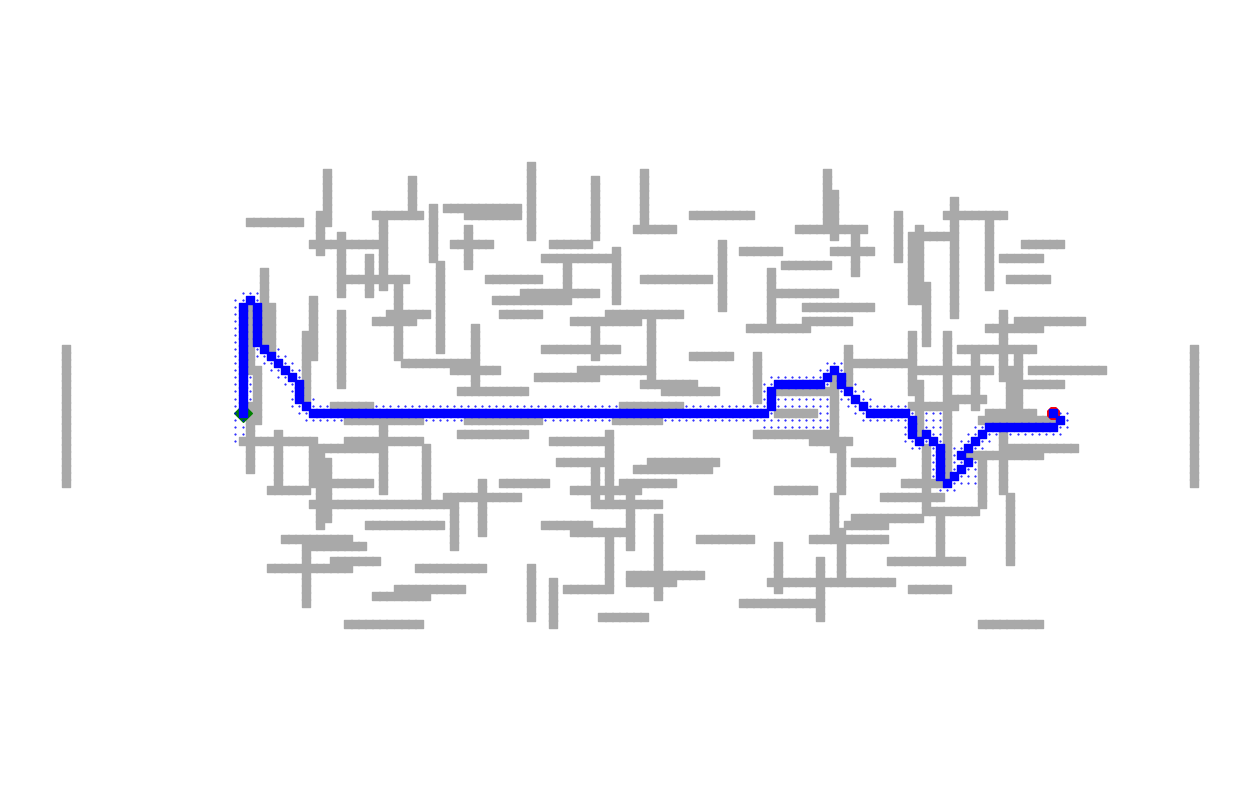

In [ ]:
solution = greedy_bfs(d3)
plot_grid_problem(d3, solution, reached, 'Greedy BFS')

A* search search: 154.2 path cost
7,418 states reached


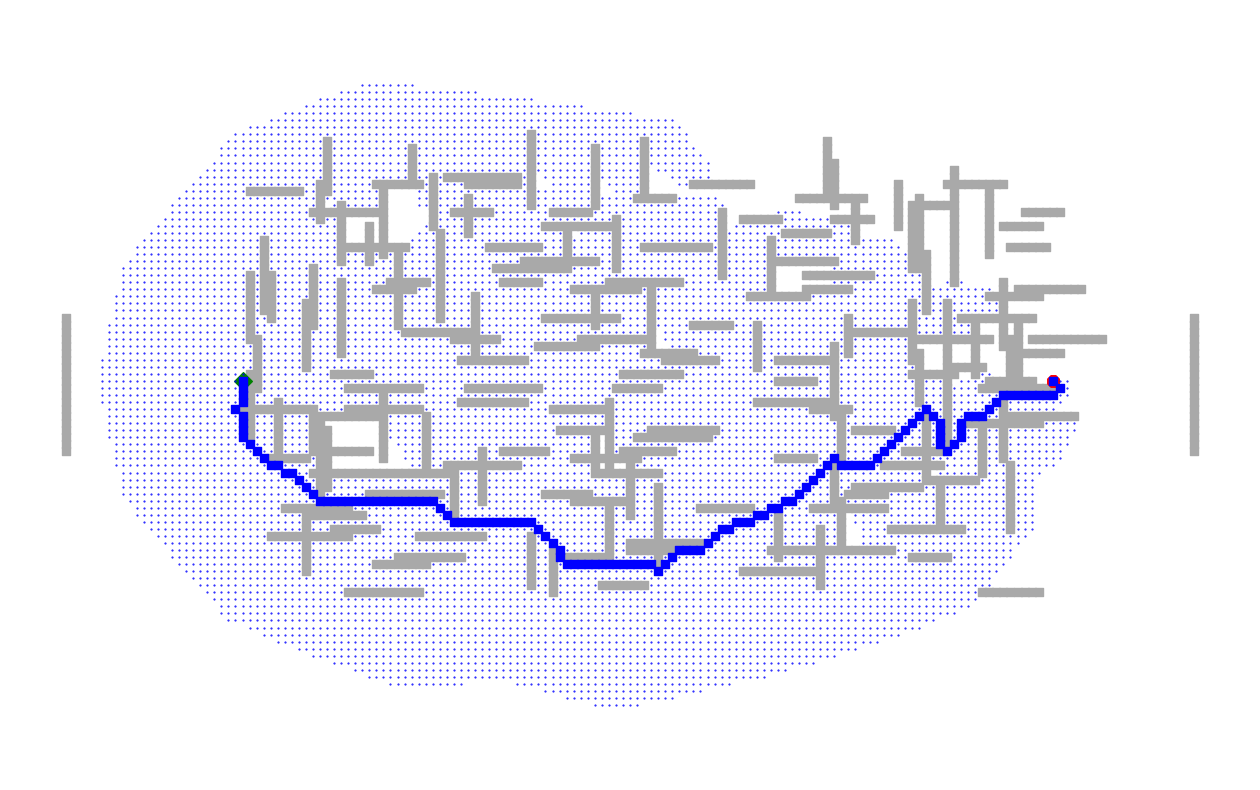

In [ ]:
solution = astar_search(d3)
plot_grid_problem(d3, solution, reached, 'A* search')

Weighted A* search: 154.2 path cost
944 states reached


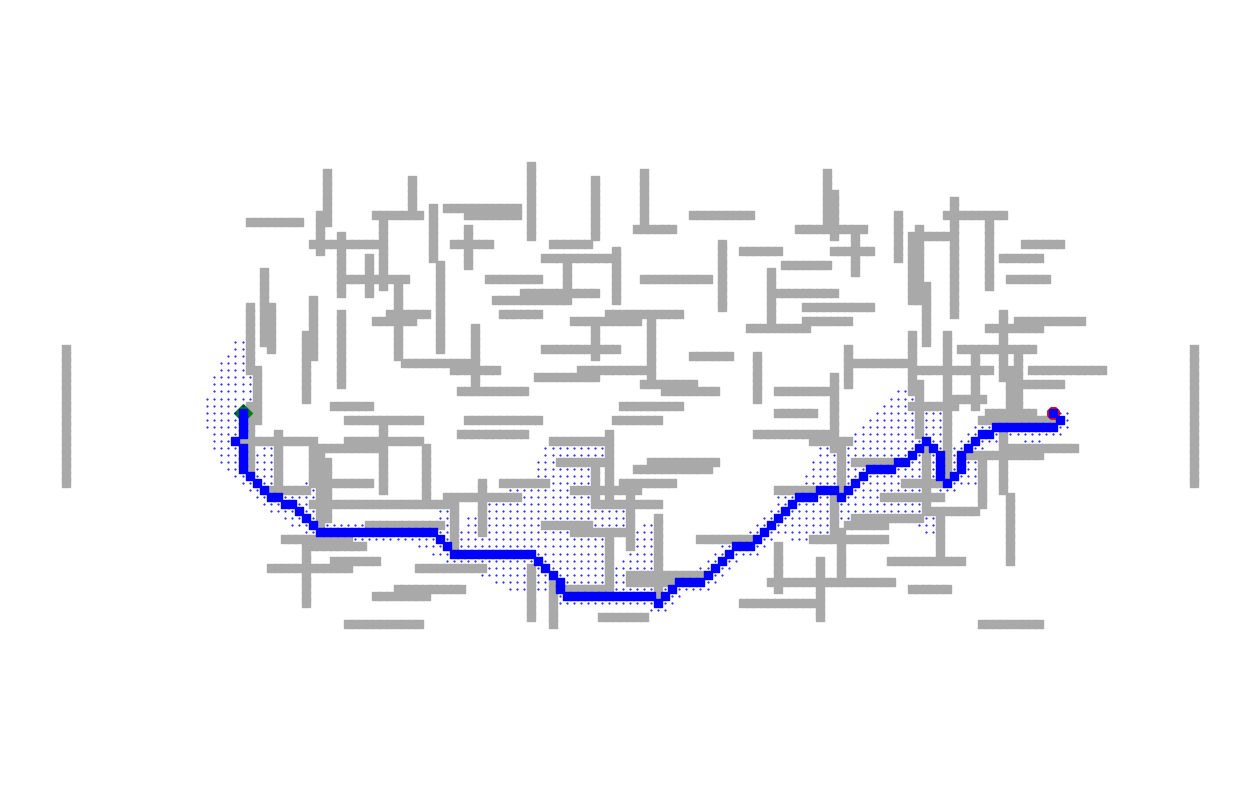

In [ ]:
solution = weighted_astar_search(d3)
plot_grid_problem(d3, solution, reached, 'Weighted A*')

# 실습 과제

### 1번

아래 상황에 대한 problem formulation(initial state, goal test, successor function, cost function)을 텍스트로 작성하시오. 실제 구현을 할 수 있을 정도로 구체적으로 작성하시오.

1.   n × n 개의 정사각형 격자가 있으며, 각 정사각형은 처음에는 칠하지 않은 바닥이거나 바닥이 없는 구덩이이다. 칠하지 않은 바닥 정사각형에서 시작하며, 아래에 있는 정사각형을 칠하거나 인접한 칠하지 않은 바닥 정사각형으로 이동할 수 있다. 바닥 전체를 칠해야 한다.
2.   12리터, 8리터, 3리터으로 측정되는 3개의 주전자와 수도꼭지가 있다. 주전자들을 가득 채우거나 이것들을 하나에서 다른 것으로 비울 수 있다. 정확히 1리터을 측정하고자 한다.

1.

Initial state: Any state of at least 1 unpainted floor square

Goal state: The state in which all floor squares are painted

Successor function:
- Paint: paints an its current located unpainted floor square
- Forward: moves the agent ahead by one floor square
- Backward: moves the agent in the opposite direction by one floor square
- TurnLeft: agent changes its direction to the left by 90 degrees
- TurnRight: agent changes its direction to the right by 90 degrees
- *all actions above have no effect if the agent encounters a hole

Cost function: uniform cost

2.

Initial state: state with all 3 kettles empty

Goal state: states with exactly 1L of water in either 1 kettle

Successor function:
- Fill: fills the chosen kettle full
- Pour: pours the water to another kettle (ensuring that pouring stops when the target kettle is full, the source kettle is empty, or the source kettle's content entirely fills the target kettle)
- Empty: empties the kettle entirely

Cost function: uniform cost

### 2번

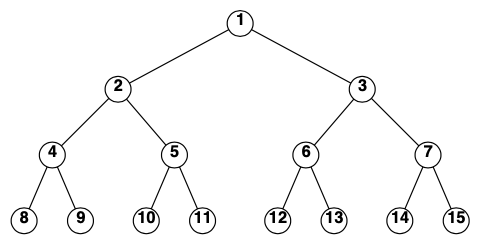

Initial state이 1이며 goal state은 11일때, 1) breadth-first search, 2)  limit이 3 인 depth-limited search, 3) iterative deepening search을 실행했을 때 방문하게 되는 노드 번호를 각 탐색 알고리즘마다 작성하시오.

1) 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 11

2) 1 -> 2 -> 4 -> 8 -> 9 -> 5 -> 10 -> 11

3) 1 -> 2 -> 4 -> 8 -> 9 -> 5 -> 10 -> 11

### 3번

GridProblem의 `d6`, `d7` 그리드에 1) `greedy_bfs`, 2) `astar_search`, 3) `weighted_astar_search` with weight `1.4`, 4) `weighted_astar_search` with weight `2`을 적용하여 탐색의 결과를 출력하시오. 출력된 결과를 바탕으로 각 알고리즘의 optimality와 reached state의 크기를 비교분석하시오.

Greedy BFS search: 133.9 path cost
758 states reached


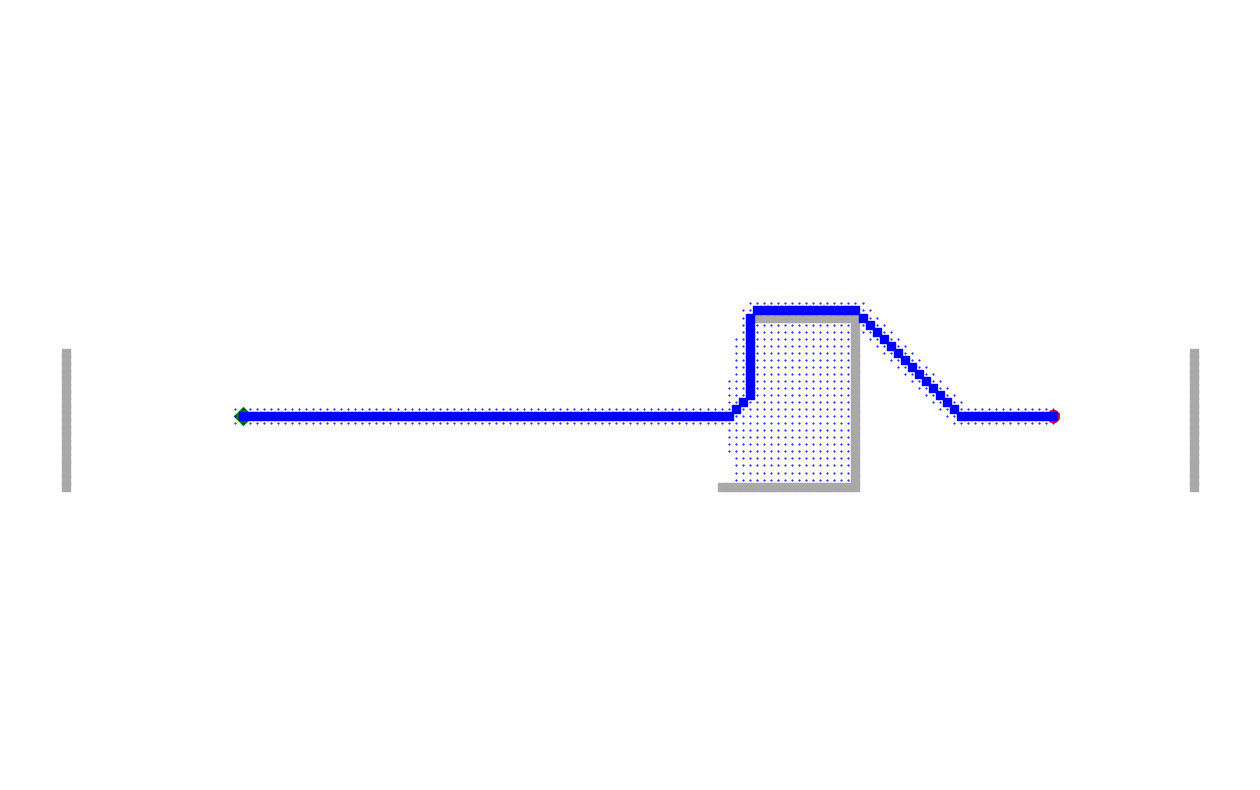

In [ ]:
solution = greedy_bfs(d6)
plot_grid_problem(d6, solution, reached, 'Greedy BFS')

Greedy BFS search: 151.6 path cost
830 states reached


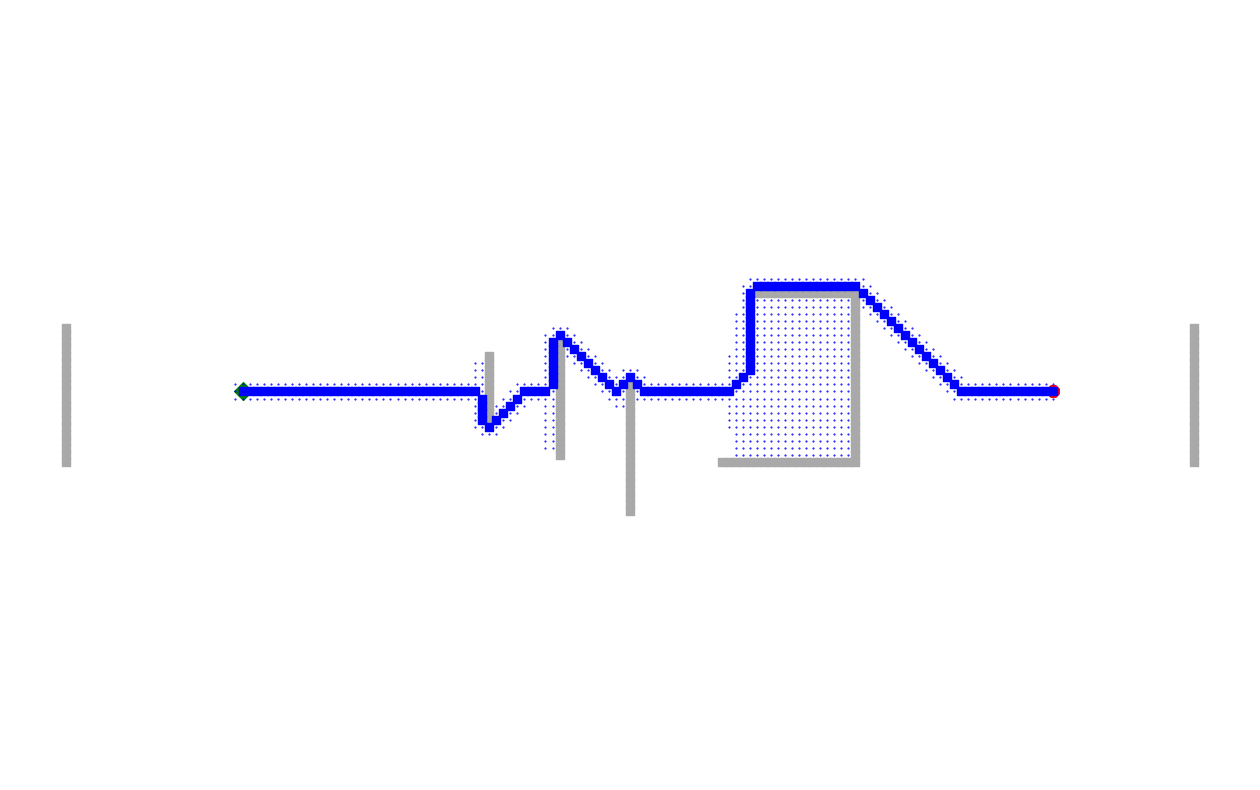

In [ ]:
solution = greedy_bfs(d7)
plot_grid_problem(d7, solution, reached, 'Greedy BFS')

A* search search: 124.1 path cost
3,305 states reached


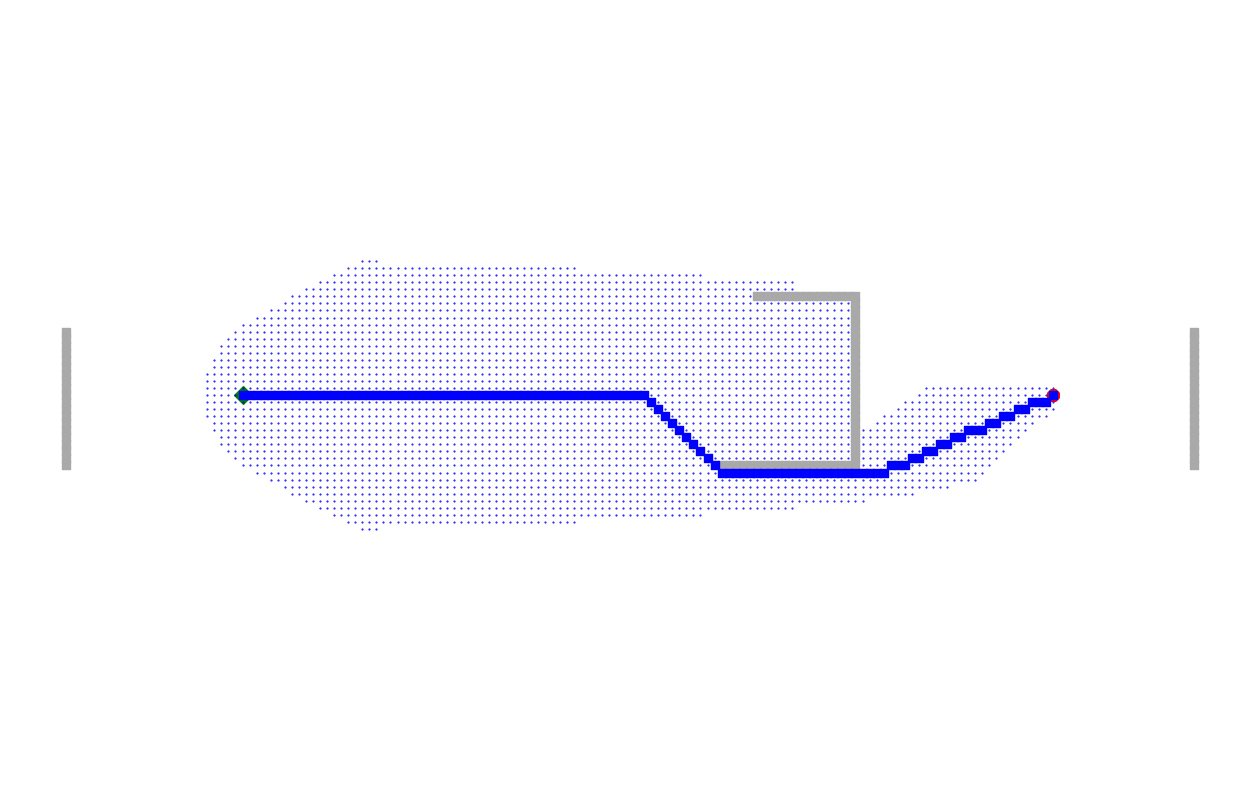

In [ ]:
solution = astar_search(d6)
plot_grid_problem(d6, solution, reached, 'A* search')

A* search search: 127.4 path cost
4,058 states reached


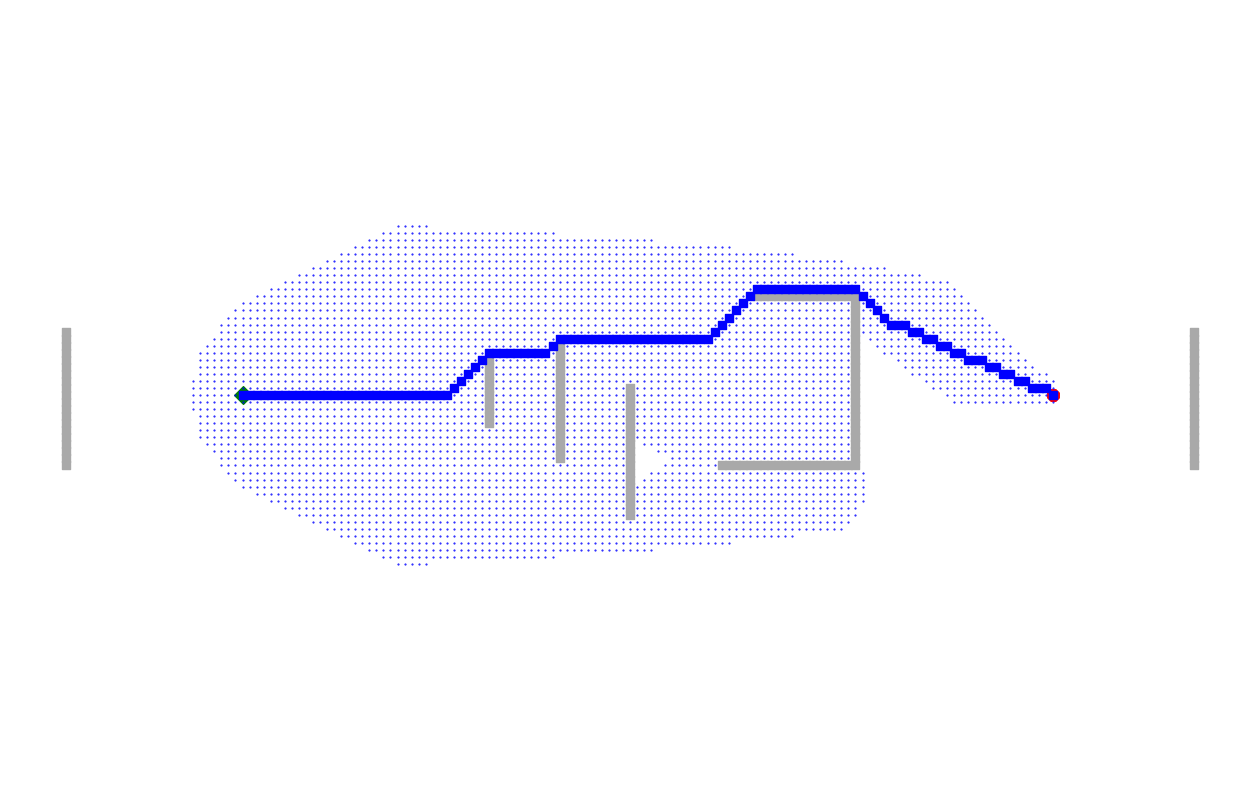

In [ ]:
solution = astar_search(d7)
plot_grid_problem(d7, solution, reached, 'A* search')

Weighted A* search: 124.1 path cost
976 states reached


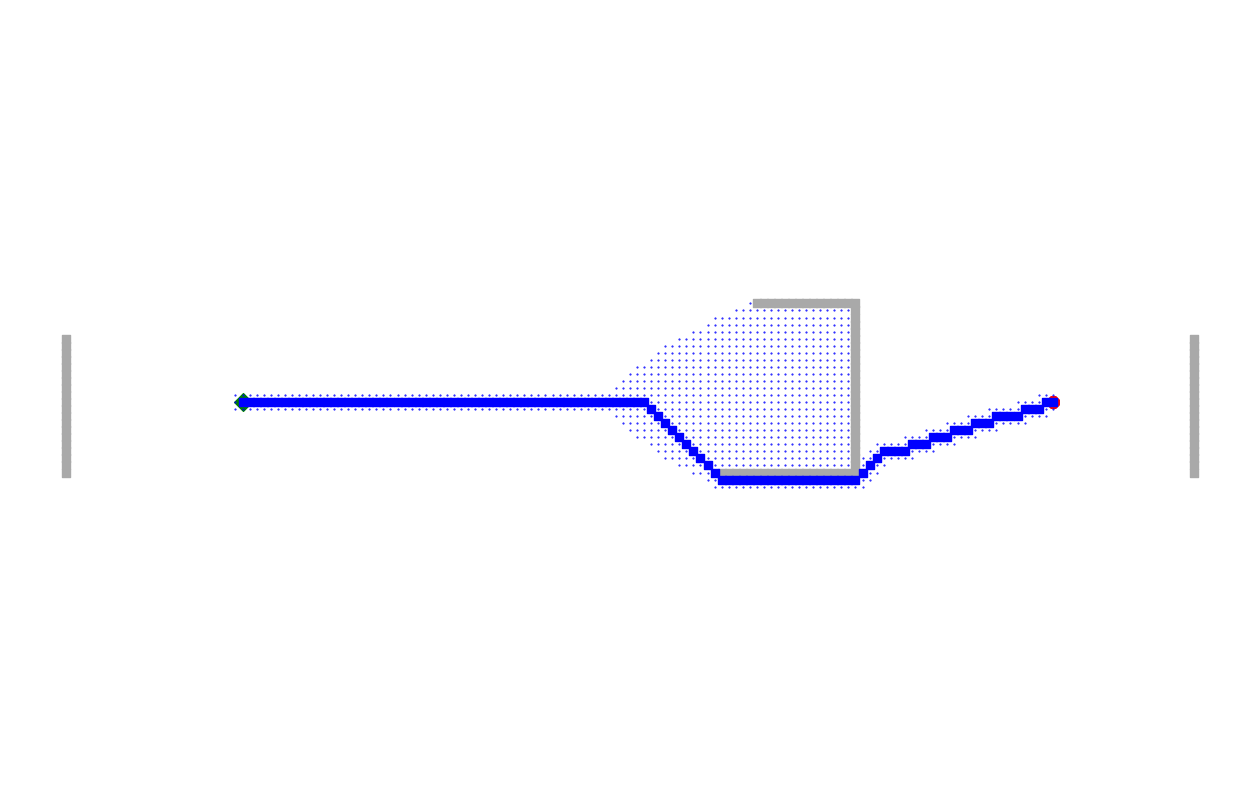

In [ ]:
solution = weighted_astar_search(d6)
plot_grid_problem(d6, solution, reached, 'Weighted A*')

Weighted A* search: 127.4 path cost
1,290 states reached


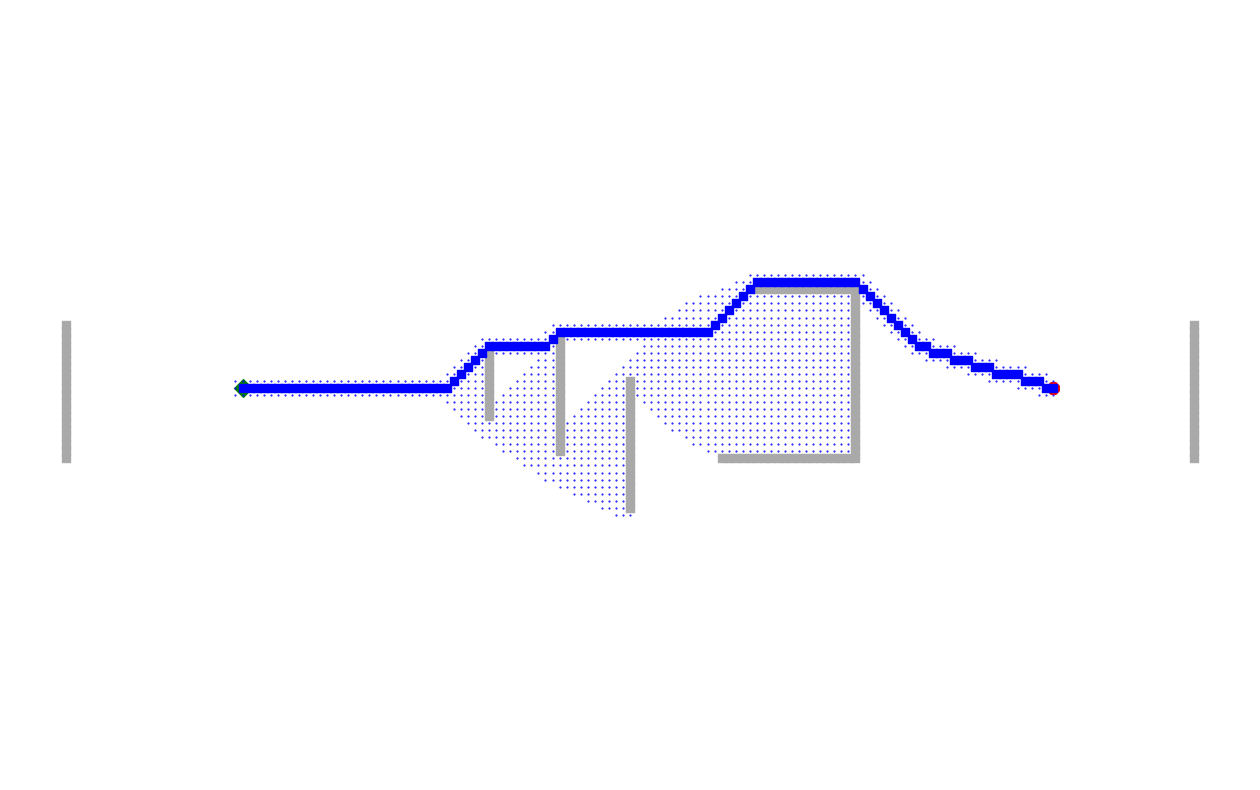

In [ ]:
solution = weighted_astar_search(d7)
plot_grid_problem(d7, solution, reached, 'Weighted A*')

Weighted A* search: 128.6 path cost
879 states reached


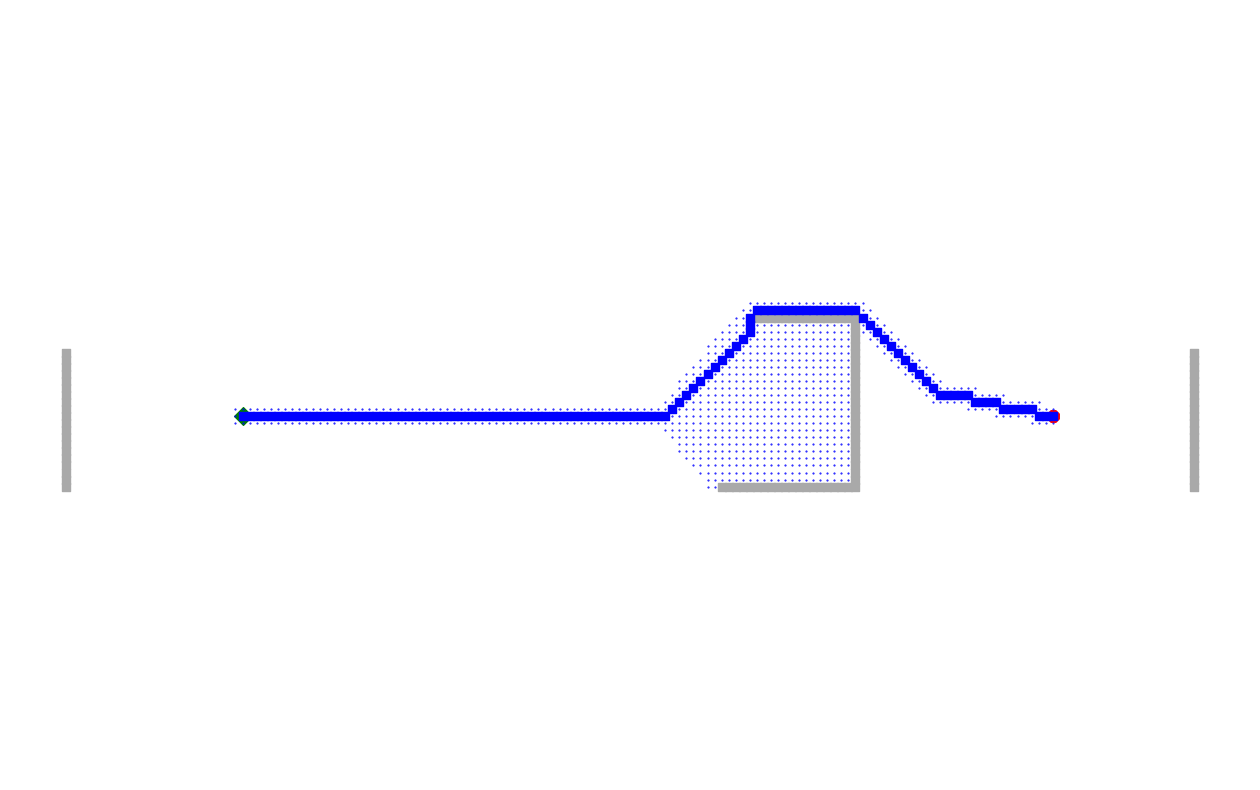

In [ ]:
solution = weighted_astar_search(d6, weight = 2)
plot_grid_problem(d6, solution, reached, 'Weighted A*')

Weighted A* search: 140.4 path cost
980 states reached


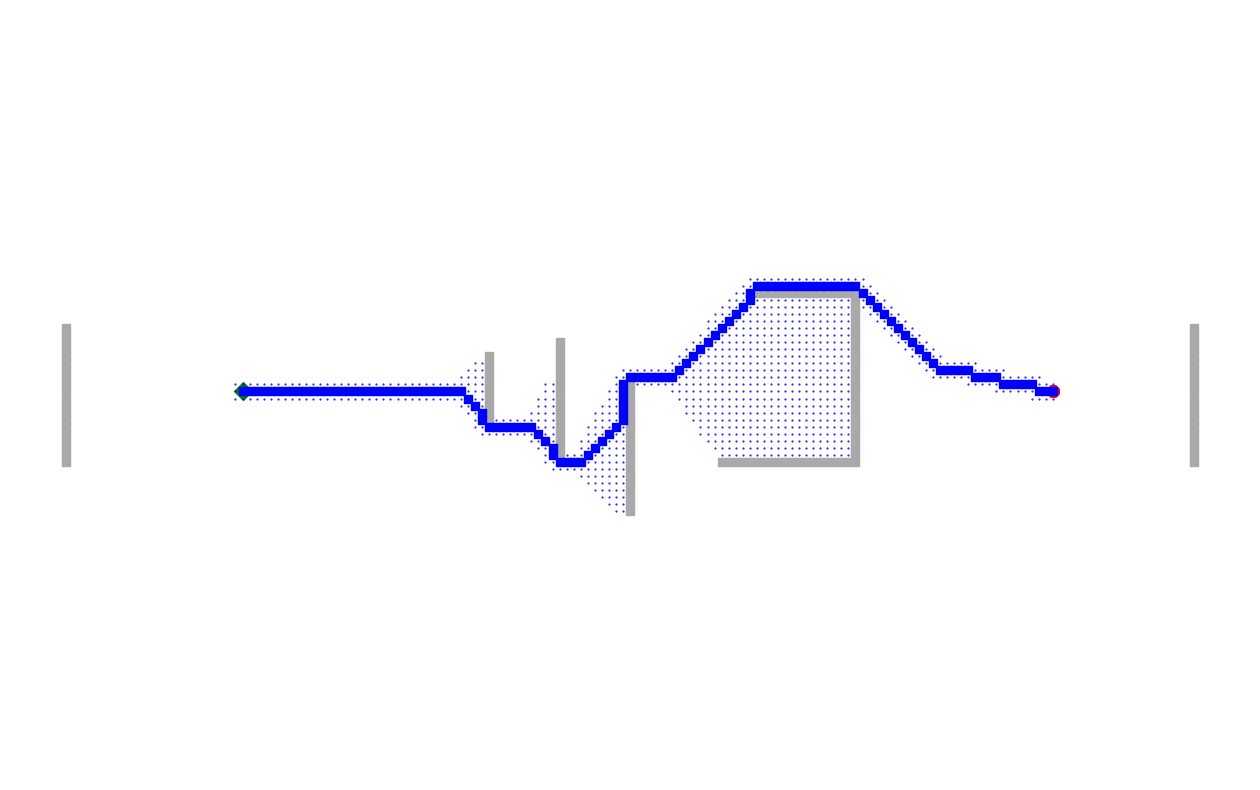

In [ ]:
solution = weighted_astar_search(d7, weight = 2)
plot_grid_problem(d7, solution, reached, 'Weighted A*')

ascending number of states reached:
greedy best-first-search < weighted A* search (weight = 2) < weighted A* search (weight = 1.4) < A* search

ascending path cost:
A* star search = weighted A* search (weight = 1.4) < weighted A* search (weight = 2) < greedy best-first-search

if we consider cost optimality as our priority, then A* star search and weighted A* search (weight = 1.4) are the most ideal algorithms to find the cheapest path to the goal.

### 4번

In [ ]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal

    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]

    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)

    def h1(self, node):
        """The misplaced tiles heuristic."""
        return misplaced_tiles_heuristic(node.state, self.goal)

    def h2(self, node):
        """The Manhattan heuristic."""
        return manhattan_distance_heuristic(node.state, self.goal)

    def h(self, node): return EightPuzzle.h1(self, node)


def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))


def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

class Board(defaultdict):
    empty = '.'
    off = '#'
    def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height)
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

    def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty

    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))

    def __hash__(self):
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

In [ ]:
e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))

In [ ]:
print(board8(e1.initial))

1 4 2
_ 7 5
3 6 8



1) 아래의 `misplaced_tiles_heuristic와` `manhattan_distance_heuristic` 함수들을 구현하고 간단한 documentation을 작성하시오. 작성된 test를 통해 구현 코드가 올바른지 확인하시오.

*   `misplaced_tiles_heuristic(A, B)`: 잘못 배치된 타일의 수(공백 미포함)
*   `manhattan_distance_heuristic(A, B)`: 타일의 목표 위치로부터의 거리의 합. 타일은 대각선을 따라 이동할 수 없기 때문에 거리는 가로 및 세로 거리의 합이다.



In [ ]:
def misplaced_tiles_heuristic(state, goal):
  return sum(1 for s, g in zip(state, goal) if s != g and s != 0)

In [ ]:
def manhattan_distance_heuristic(state, goal):
    distance = 0
    for s in state:
        if s != 0:
            s_index = state.index(s)
            g_index = goal.index(s)
            row_distance = abs(s_index // 3 - g_index // 3)
            column_distance = abs(s_index % 3 - g_index % 3)
            distance += row_distance + column_distance
    return distance

In [ ]:
# test case
node1 = Node(e3.initial)
assert e3.h1(node1) == 7
assert e3.h2(node1) == 11

node2 = Node(e4.initial)
assert e4.h1(node2) == 8
assert e4.h2(node2) == 18

2) 아래 알고리즘을 `e1`, `e2`, `e3`, `e4`, `e5` 보드에 적용하고 그 결과를 `report` 함수를 통해 출력하시오.

*   breadth_first_search: h = 0
*   A* search with misplaced tiles heuristic
*   A* search with Manhattan distance heuristic

특정 heuristic이 적용된 탐색 알고리즘 함수 생성 예시:

  ```
  def astar_misplaced_tiles(problem):
      return astar_search(problem, h=problem.h1)
  ```

In [ ]:
def astar_misplaced_tiles(problem):
  return astar_search(problem, h=problem.h1)

def astar_manhattan_distance(problem):
  return astar_search(problem, h=problem.h2)

In [ ]:
report([breadth_first_search, astar_misplaced_tiles, astar_manhattan_distance],[e1, e2, e3, e4, e5])

breadth_first_search:
       81 nodes |       82 goal |    5 cost |      35 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
  160,948 nodes |  160,949 goal |   22 cost |  59,960 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
  218,263 nodes |  218,264 goal |   23 cost |  81,829 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  418,771 nodes |  418,772 goal |   26 cost | 156,533 actions | EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1),
  448,667 nodes |  448,668 goal |   27 cost | 167,799 actions | EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1),
1,246,730 nodes |1,246,735 goal |  103 cost | 466,156 actions | TOTAL

astar_misplaced_tiles:
       15 nodes |        6 goal |    5 cost |      10 actions | EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8),
   22,615 nodes |    8,330 goal |   22 cost |   8,351 actions | EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0),
   37,395 nodes |   13,816 goal |   23 cost |  13,838 actions | EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6),
  121,195 nodes |   44,989 goal |   26 cost 

3) 위 문제에서 출력된 결과를 바탕으로 uninformed search와 informed search의 차이와 각 heuristic의 차이를 알고리즘의 특성에 기반하여 비교분석하시오.

Even though the path cost is the same, uninformed search algorithms search exhaustively and generate many nodes while informed search algorithms generate much fewer nodes due to the use of heuristic functions. In particular, A* search algorithm above used information from heuristics of misplaced tiles and the manhattan distance of the tiles to achieve the goal. Hence, it can be said that informed search algorithms are likely to lead to the goal much quicker than uninformed search algorithms.